In [1]:
import rasterio
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import random
from PIL import Image

from time import time
import csv
import os
import numpy as np

import matplotlib.pyplot as plt
from random import shuffle
from itertools import compress

In [57]:
class InMemoryDataset(torch.utils.data.Dataset):
  
    def __init__(self, data_list, preprocess_func):
        self.data_list = data_list
        self.preprocess_func = preprocess_func

    def __getitem__(self, i):
        return self.preprocess_func(self.data_list[i])

    def __len__(self):
        return len(self.data_list)


def processAndAugment(data):
    (x,y) = data
    im,label = x.copy(), y.copy()

    # convert to PIL for easier transforms
    im1 = Image.fromarray(im[0])
    im2 = Image.fromarray(im[1])
    label = Image.fromarray(label.squeeze())

  # Get params for random transforms
    i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))

    im1 = F.crop(im1, i, j, h, w)
    im2 = F.crop(im2, i, j, h, w)
    label = F.crop(label, i, j, h, w)
    if random.random() > 0.5:
        im1 = F.hflip(im1)
        im2 = F.hflip(im2)
        label = F.hflip(label)
    if random.random() > 0.5:
        im1 = F.vflip(im1)
        im2 = F.vflip(im2)
        label = F.vflip(label)

    norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
    im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
    #im = norm(im)
    label = transforms.ToTensor()(label).squeeze()
    if torch.sum(label.gt(.003) * label.lt(.004)):
        label *= 255
    #label = label.round()

    return im, label

def processTestIm(data):
    (x,y) = data
    im,label = x.copy(), y.copy()
    norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])

    # convert to PIL for easier transforms
    im_c1 = Image.fromarray(im[0]).resize((512,512))
    im_c2 = Image.fromarray(im[1]).resize((512,512))
    label = Image.fromarray(label.squeeze()).resize((512,512))

    im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
    im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
    labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]

    ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]

    ims = [norm(im) for im in ims]
    ims = torch.stack(ims)

    labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
    labels = torch.stack(labels)
  
    if torch.sum(labels.gt(.003) * labels.lt(.004)):
        labels *= 255
    #labels = labels.round()
  
    return ims, labels

In [3]:
def getArrFlood(fname):
    return rasterio.open(fname).read()

def download_flood_water_data_from_list(l):
    i = 0
    tot_nan = 0
    tot_good = 0
    flood_data = []
    for (im_fname, mask_fname) in l:
        if not os.path.exists(os.path.join("files/", im_fname)):
            continue
        arr_x = np.nan_to_num(getArrFlood(os.path.join("files/", im_fname)))
        arr_y = getArrFlood(os.path.join("files/", mask_fname))
        arr_y[arr_y == -1] = 255 

        arr_x = np.clip(arr_x, -50, 1)
        arr_x = (arr_x + 50) / 51

        if i % 100 == 0:
              print(im_fname, mask_fname)
        i += 1
        flood_data.append((arr_x,arr_y))

    return flood_data

def load_flood_train_data(input_root, label_root):
    fname = "/nfs/kloe/einstein4/martino/WQeMS/flood_train_data.csv"
    training_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            training_files.append(tuple((input_root+line[0], label_root+line[1])))

    return download_flood_water_data_from_list(training_files)

def load_flood_valid_data(input_root, label_root):
    fname = "/nfs/kloe/einstein4/martino/WQeMS/flood_valid_data.csv"
    validation_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            validation_files.append(tuple((input_root+line[0], label_root+line[1])))

    return download_flood_water_data_from_list(validation_files)

def load_flood_test_data(input_root, label_root):
    fname = "/nfs/kloe/einstein4/martino/WQeMS/flood_test_data.csv"
    testing_files = []
    with open(fname) as f:
        for line in csv.reader(f):
            testing_files.append(tuple((input_root+line[0], label_root+line[1])))

    return download_flood_water_data_from_list(testing_files)

In [4]:
def f(y):
    a=0
    b=0
    cons_idx_list=list()
    for i in 1+np.arange(len(y)-1):
        if (y[i]-y[i-1]==0 or y[i]-y[i-1]==1):
            #a=cons_b_idx[i-1]
            b=i
            if i==len(y)-1:
                x=np.intersect1d(np.arange(a,b+1),np.where(y!=255)[0])
                if len(x)>0:
                    cons_idx_list.append(x)
        else:
            x=np.intersect1d(np.arange(a,b+1),np.where(y!=255)[0])
            if len(x)>0:
                cons_idx_list.append(x)
            a=i
        #print(i)
    return cons_idx_list

    #print(i,a,b)

In [5]:
#t_size=252
min_tlenght_cut=2

In [89]:
def get_timeseries_train(dataset):
    y_list=list()
    hoty_list=list()
    #ch_0_list=list()
    #ch_1_list=list()
    data=list()
    counter=0
    
    t_size=len(dataset[:])
    for i in np.arange(256):
        for j in np.arange(256):
            if counter==10000:
                break
            #j=100
            ch_0=list()
            ch_1=list()
            y=list()
            for t in np.arange(t_size):#len(train_data)):
                ch_0.append(float(dataset[t][0][0][i,j]))
                ch_1.append(float(dataset[t][0][1][i,j]))
                y.append(int(dataset[t][1][i,j]))

            ch_0=np.array(ch_0)
            ch_1=np.array(ch_1)    
            y=np.array(y)


            idx=f(y)
            for k in np.arange(len(idx)):
                y_list.append(np.array(y[idx[k]]))
                if 1 in y[idx[k]]:
                    hoty_list.append([1])
                else:
                    hoty_list.append([0])
                #ch_0_list.append(np.array(ch_0[idx[k]]))
                #ch_1_list.append(np.array(ch_1[idx[k]]))
                data.append(np.array([np.array(ch_0[idx[k]]),np.array(ch_1[idx[k]])]).reshape(2,len(idx[k])))
            counter+=1
            if (counter)%1000==0:
                print(counter/256**2,len(y_list))
        #print(len(y_list))
    return data,y_list

def get_timeseries_test(dataset):
    y_list=list()
    hoty_list=list()
    #ch_0_list=list()
    #ch_1_list=list()
    data=list()
    counter=0
    
    t_size=len(dataset[:])
    for i in np.arange(256):
        for j in np.arange(256):
            if counter==10000:
                break
            #j=100
            ch_0=list()
            ch_1=list()
            y=list()
            for t in np.arange(t_size):#len(train_data)):
                ch_0.append(float(dataset[t][0][0][0][i,j]))
                ch_1.append(float(dataset[t][0][0][1][i,j]))
                y.append(int(dataset[t][1][0][i,j]))

            ch_0=np.array(ch_0)
            ch_1=np.array(ch_1)    
            y=np.array(y)


            idx=f(y)
            for k in np.arange(len(idx)):
                y_list.append(np.array(y[idx[k]]))
                if 1 in y[idx[k]]:
                    hoty_list.append([1])
                else:
                    hoty_list.append([0])
                #ch_0_list.append(np.array(ch_0[idx[k]]))
                #ch_1_list.append(np.array(ch_1[idx[k]]))
                data.append(np.array([np.array(ch_0[idx[k]]),np.array(ch_1[idx[k]])]).reshape(2,len(idx[k])))
            counter+=1
            if (counter)%1000==0:
                print(counter/256**2,len(y_list))
        #print(len(y_list))
    return data,y_list

In [7]:
def get_rawtimeseries(dataset):
    y_list=list()
    hoty_list=list()
    #ch_0_list=list()
    #ch_1_list=list()
    data=list()
    counter=0
    
    t_size=len(dataset[:])
    for i in np.arange(256):
        for j in np.arange(256):
            if counter==10000:
                break
            #j=100
            ch_0=list()
            ch_1=list()
            y=list()
            for t in np.arange(t_size):#len(train_data)):
                ch_0.append(float(dataset[t][0][0][i,j]))
                ch_1.append(float(dataset[t][0][1][i,j]))
                y.append(int(dataset[t][1][0][i,j]))

            ch_0=np.array(ch_0)
            ch_1=np.array(ch_1)    
            y=np.array(y)


            idx=f(y)
            for k in np.arange(len(idx)):
                y_list.append(np.array(y[idx[k]]))
                if 1 in y[idx[k]]:
                    hoty_list.append([1])
                else:
                    hoty_list.append([0])
                #ch_0_list.append(np.array(ch_0[idx[k]]))
                #ch_1_list.append(np.array(ch_1[idx[k]]))
                data.append(np.array([np.array(ch_0[idx[k]]),np.array(ch_1[idx[k]])]).reshape(2,len(idx[k])))
            counter+=1
            if (counter)%1000==0:
                print(counter/256**2,len(y_list))
        #print(len(y_list))
    return data,y_list

In [8]:
def create_dataset(data,y_list):
    selected_signal_idx=list()
    selected_bkg_idx=list()
    for k in np.arange(len(y_list)):
        if y_list[k].sum()>min_tlenght_cut:
            selected_signal_idx.append(k)
        if y_list[k].sum()==0 and len(y_list[k])>min_tlenght_cut:
            selected_bkg_idx.append(k)
    selected_signal_idx=np.array(selected_signal_idx)
    selected_bkg_idx=np.array(selected_bkg_idx)
    
    selected_signal_mask=np.zeros(len(y_list),dtype=bool)
    selected_bkg_mask=np.zeros(len(y_list),dtype=bool)
    for k in selected_signal_idx:
            selected_signal_mask[k]=True
    for k in selected_bkg_idx:
            selected_bkg_mask[k]=True

    selected_data_sig=list(compress(data, selected_signal_mask))
    selected_data_bkg=list(compress(data, selected_bkg_mask))
    selected_y_sig=list(compress(y_list,selected_signal_mask))
    selected_y_bkg=list(compress(y_list,selected_bkg_mask))

    selected_data=selected_data_sig+selected_data_bkg
    #selected_data.append(selected_data_bkg)
    selected_y=np.ones(len(selected_data_sig))
    selected_y=np.append(selected_y,np.zeros(len(selected_data_bkg)))

    print('data size:',len(selected_data),len(selected_y))

    c = list(zip(selected_data, selected_y))

    random.shuffle(c)

    selected_data, selected_y = zip(*c)
    selected_y=np.array(selected_y)
    
    return selected_data, selected_y

In [96]:
def reorder_ragged_data(selected_data,selected_y):
    
    l=list([])
    size=len(selected_y)
    print(size)
    for k in np.arange(size):
        l.append(selected_data[k].shape[1])

    max_tlenght=max(l)
    ragged_data=list()
    ragged_y=list()
    recurrence=list()
    for s in np.arange(min_tlenght_cut+1,max_tlenght):
        count=0
        sel_data_tmp=list()
        sel_y_tmp=list()
        for k in np.arange(selected_y.shape[0]):
            if selected_data[k][0].shape[0]==s:
                #print(count)
                sel_data_tmp.append(selected_data[k].T)
                sel_y_tmp.append(selected_y[k])
                count+=1
        recurrence.append(count)
        sel_data_tmp=np.array(sel_data_tmp)
        sel_y_tmp=np.array(sel_y_tmp)

        ragged_data.append(sel_data_tmp)
        ragged_y.append(sel_y_tmp)
    return ragged_data,ragged_y,max_tlenght



def reorder_split_data(selected_data,selected_y):

    ragged_data,ragged_y,max_tlenght=reorder_ragged_data(selected_data,selected_y)
    
    sel_data_flatten_ch0_sig=list()
    sel_data_flatten_ch1_sig=list()
    sel_data_flatten_ch0_bkg=list()
    sel_data_flatten_ch1_bkg=list()
    for k in np.arange(max_tlenght-min_tlenght_cut-1):
        #print(k)
        sel_data_flatten_ch0_sig.append(ragged_data[k][ragged_y[k]==1,:,0].flatten())
        sel_data_flatten_ch1_sig.append(ragged_data[k][ragged_y[k]==1,:,1].flatten())
        sel_data_flatten_ch0_bkg.append(ragged_data[k][ragged_y[k]==0,:,0].flatten())
        sel_data_flatten_ch1_bkg.append(ragged_data[k][ragged_y[k]==0,:,1].flatten())

    sel_data_flatten_ch0_sig=np.concatenate(sel_data_flatten_ch0_sig).ravel()
    sel_data_flatten_ch1_sig=np.concatenate(sel_data_flatten_ch1_sig).ravel()
    sel_data_flatten_ch0_bkg=np.concatenate(sel_data_flatten_ch0_bkg).ravel()
    sel_data_flatten_ch1_bkg=np.concatenate(sel_data_flatten_ch1_bkg).ravel()
    return sel_data_flatten_ch0_sig,sel_data_flatten_ch1_sig,sel_data_flatten_ch0_bkg,sel_data_flatten_ch1_bkg

In [24]:
train_data = load_flood_train_data('/nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/S1Hand/', '/nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/LabelHand/')

/nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_103272_S1Hand.tif /nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_103272_LabelHand.tif
/nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/S1Hand/Pakistan_132143_S1Hand.tif /nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/LabelHand/Pakistan_132143_LabelHand.tif
/nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/S1Hand/Sri-Lanka_916628_S1Hand.tif /nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/LabelHand/Sri-Lanka_916628_LabelHand.tif


In [10]:
test_data = load_flood_test_data('/nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/S1Hand/', '/nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/LabelHand/')

/nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_313799_S1Hand.tif /nfs/kloe/einstein4/martino/WQeMS/v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_313799_LabelHand.tif


In [33]:
len(test_data[:]),len(train_data[:])

(90, 252)

In [24]:
data_raw,y_list_raw = get_rawtimeseries(train_data)

0.0152587890625 38391
0.030517578125 76878
0.0457763671875 115359
0.06103515625 153422
0.0762939453125 191628
0.091552734375 230021
0.1068115234375 268421
0.1220703125 306838
0.1373291015625 345435
0.152587890625 383779


In [27]:
selected_raw_data, selected_raw_y = create_dataset(data_raw,y_list_raw)

data size: 154188 154188


In [63]:
sel_data_flatten_ch0_sig_raw,sel_data_flatten_ch1_sig_raw,sel_data_flatten_ch0_bkg_raw,sel_data_flatten_ch1_bkg_raw = reorder_split_data(selected_raw_data,selected_raw_y)


In [58]:
test_dataset=list()
for t in np.arange(len(test_data)):
#    test_dataset.append(processAndAugment(test_data[t]))
    test_dataset.append(processTestIm(test_data[t]))

In [90]:
test_data_raw,test_y_list_raw = get_timeseries_test(test_dataset)

0.0152587890625 14205
0.030517578125 28000
0.0457763671875 41823
0.06103515625 55969
0.0762939453125 70273
0.091552734375 84862
0.1068115234375 99399
0.1220703125 113820
0.1373291015625 128313
0.152587890625 143264


In [91]:
selected_raw_test_data, selected_raw_test_y = create_dataset(test_data_raw,test_y_list_raw)

data size: 63254 63254


In [92]:
ragged_test_data,ragged_test_y,t_max = reorder_ragged_data(selected_raw_test_data, selected_raw_test_y)


63254


In [98]:
ch0_sig,ch1_sig,ch0_bkg,ch1_bkg=reorder_split_data(selected_raw_test_data, selected_raw_test_y)

63254


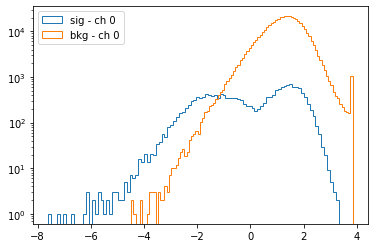

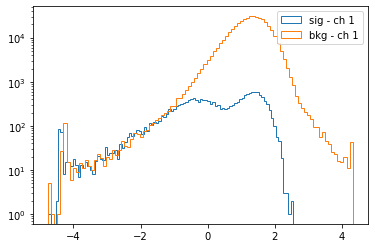

In [99]:
plt.hist(ch0_sig,bins=100,histtype='step',label='sig - ch 0')
plt.hist(ch0_bkg,bins=100,histtype='step',label='bkg - ch 0')
plt.yscale('log')
plt.legend()
plt.show()
plt.hist(ch1_sig,bins=100,histtype='step',label='sig - ch 1')
plt.hist(ch1_bkg,bins=100,histtype='step',label='bkg - ch 1')
plt.yscale('log')
plt.legend()
plt.show()

In [11]:
train_dataset=list()
for t in np.arange(len(train_data)):
    train_dataset.append(processAndAugment(train_data[t]))

In [12]:
data_preprocessed, y_list = get_timeseries_train(train_dataset)

0.0152587890625 34292
0.030517578125 68276
0.0457763671875 101608
0.06103515625 135347
0.0762939453125 169199
0.091552734375 203234
0.1068115234375 237334
0.1220703125 271467
0.1373291015625 304852
0.152587890625 337719


In [13]:
selected_data, selected_y = create_dataset(data_preprocessed, y_list)

data size: 152823 152823


In [14]:
sel_data_flatten_ch0_sig,sel_data_flatten_ch1_sig,sel_data_flatten_ch0_bkg,sel_data_flatten_ch1_bkg = reorder_split_data(selected_data,selected_y)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


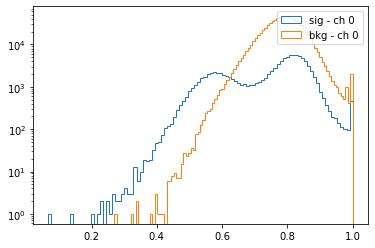

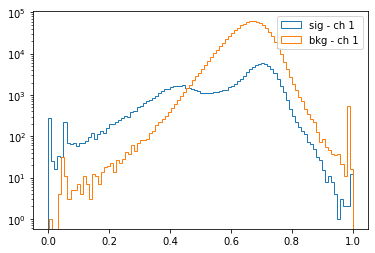

In [15]:
plt.hist(sel_data_flatten_ch0_sig,bins=100,histtype='step',label='sig - ch 0')
plt.hist(sel_data_flatten_ch0_bkg,bins=100,histtype='step',label='bkg - ch 0')
plt.yscale('log')
plt.legend()
plt.show()
plt.hist(sel_data_flatten_ch1_sig,bins=100,histtype='step',label='sig - ch 1')
plt.hist(sel_data_flatten_ch1_bkg,bins=100,histtype='step',label='bkg - ch 1')
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
import pickle
import os

path='/afs/le.infn.it/user/c/centonze/WQeMS/dataset_log/'
directory=path+'data'

In [16]:
if not os.path.exists(path):
    os.makedirs(path)
    
with open(path+'data', "wb") as fp:   #Pickling
    pickle.dump(data, fp)

In [17]:
y=np.array(hoty_list)
with open(path+'labels', "wb") as labs:   #Pickling
    pickle.dump(y, labs)

In [18]:
with open(path+'labels_complete', "wb") as labs:   #Pickling
    pickle.dump(y_list, labs)

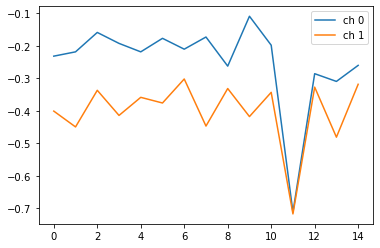

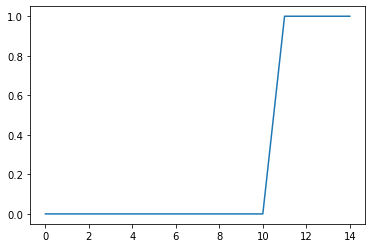

In [40]:
k=2
plt.plot(np.arange(selected_data_sig[k][0].shape[0]),selected_data_sig[k][0],label='ch 0')
plt.plot(np.arange(selected_data_sig[k][0].shape[0]),selected_data_sig[k][1],label='ch 1')
plt.legend()
plt.show()

plt.plot(np.arange(selected_data_sig[k][0].shape[0]),selected_y_sig[k],label='y')
plt.show()

In [42]:
#list(compress(selected_data,selected_y==1))[0]

with open(path+'selected_data_2', "wb") as s_data:   #Pickling
    pickle.dump(selected_data, s_data)
    
with open(path+'selected_y_2', "wb") as s_y:   #Pickling
    pickle.dump(selected_y, s_y)

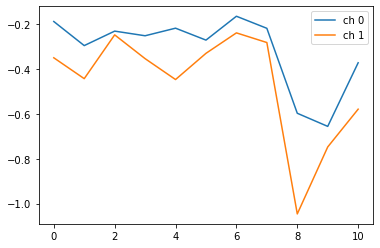

In [43]:
k=1
plt.plot(np.arange(list(compress(selected_data,selected_y==1))[0][0].shape[0]),list(compress(selected_data,selected_y==1))[0][0],label='ch 0')
plt.plot(np.arange(list(compress(selected_data,selected_y==1))[0][0].shape[0]),list(compress(selected_data,selected_y==1))[0][1],label='ch 1')
plt.legend()
plt.show()

#plt.plot(np.arange(selected_data_bkg[k][0].shape[0]),selected_y_bkg[k],label='y')
#plt.show()

lenght: 5 sig fraction: 0.041705654324288195


ValueError: supplied range of [-inf, 0.0] is not finite

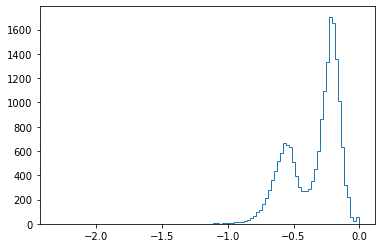

In [48]:
k=2#4#9
print('lenght:', k+3,'sig fraction:',np.where(ragged_y[k]==1)[0].shape[0]/ragged_y[k].shape[0])
plt.hist(ragged_data[k][ragged_y[k]==1,:,0].flatten(),bins=100,histtype='step',label='sig - ch 0')
plt.hist(ragged_data[k][ragged_y[k]==0,:,0].flatten(),bins=100,histtype='step',label='bkg - ch 0')
plt.yscale('log')
plt.legend()
plt.show()
plt.hist(ragged_data[k][ragged_y[k]==1,:,1].flatten(),bins=100,histtype='step',label='sig - ch 1')
plt.hist(ragged_data[k][ragged_y[k]==0,:,1].flatten(),bins=100,histtype='step',label='bkg - ch 1')
plt.yscale('log')
plt.legend()
plt.show()